# Step 4: Model Development

---

In [51]:
# Imports and environment setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')


from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Custom utils functions
from utils.visualization import header

We will store our models and their performance in the following variables:

- `clfs`: All models.
- `clfs`: Selected models that has the most potential.
- `clf_final`: The final model we will use to predict `data/Paitients_Files_Train.csv`

In [52]:
clfs = dict()
clfs_candidates = dict()
clf_final = None

## 1. Logistic Regression

Our problem requires classification prediction. Logistic regression is one of the appropriate algorithm to base our model on.

We would develop and evaluate the following models to find the best candidate for our problem:

- Logistic Regression with Linear Features and $L_1$ Regularization (`clf_logistic1_l1`);
- Logistic Regression with Linear Features and $L_2$ Regularization (`clf_logistic1_l2`);
- Logistic Regression with Polynomial Features of degree 2 and $L_1$ Regularization (`clf_logistic2_l1`);
- Logistic Regression with Polynomial Features of degree 2 and $L_2$ Regularization (`clf_logistic2_l2`);
- Logistic Regression with Polynomial Features of degree 3 and $L_1$ Regularization (`clf_logistic3_l1`).
- Logistic Regression with Polynomial Features of degree 3 and $L_2$ Regularization (`clf_logistic3_l2`).

For regularization, we will be using Grid Search method to select lamda values.

For performance evaluation, we will be using [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) to measure our models' performance and optimize them. While every sepsis case needs immediate attention, thus every potential sepsis patient needs close monitering, false positive predictions might take medical resources away from patients that might actually need it. In subsequent model development, if we see that recall and precision have different weights in our problem domain, we can switch to [$F-beta](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#:~:text=The%20F-beta%20score%20is,recall%20in%20the%20combined%20score.) instead.

For this, we will use processed datasets from [Step 3. Data Processing - Logistic Regression](Step3_DataProcessing/LogisticRegression.ipynb).

In [53]:
df_train = pd.read_csv("../data/processed_LogisticRegression_train.csv")
df_test = pd.read_csv("../data/processed_LogisticRegression_test.csv")

In [54]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRG     782 non-null    float64
 1   PL      782 non-null    float64
 2   PR      782 non-null    float64
 3   SK      782 non-null    float64
 4   TS      782 non-null    float64
 5   M11     782 non-null    float64
 6   BD2     782 non-null    float64
 7   Age     782 non-null    float64
 8   Sepsis  782 non-null    float64
dtypes: float64(9)
memory usage: 55.1 KB


,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepsis
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.00000
mean,0.093303,0.120884,0.053327,0.066275,0.094252,0.079220,0.081804,0.107794,0.50000
std,0.981172,0.991983,1.024143,0.972240,0.993948,0.979384,1.007280,1.002119,0.50032
min,-1.739748,-3.875880,-3.277139,-3.720660,-1.784871,-2.680662,-2.664330,-1.288830,0.00000
25%,-0.756075,-0.554200,-0.471875,-0.524925,-0.325599,-0.588994,-0.642949,-0.713537,0.00000
50%,0.164328,0.120653,0.097826,-0.066467,-0.325599,0.143147,0.133515,-0.003753,0.50000
75%,0.803661,0.835510,0.787667,0.786756,0.522600,0.726554,0.911406,0.918774,1.00000
max,1.787925,2.066296,2.182884,2.050475,1.652611,2.195947,1.855361,2.256671,1.00000


In [55]:
df_test.info()
df_test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRG     169 non-null    float64
 1   PL      169 non-null    float64
 2   PR      169 non-null    float64
 3   SK      169 non-null    float64
 4   TS      169 non-null    float64
 5   M11     169 non-null    float64
 6   BD2     169 non-null    float64
 7   Age     169 non-null    float64
dtypes: float64(8)
memory usage: 10.7 KB


,PRG,PL,PR,SK,TS,M11,BD2,Age
count,1.690000e+02,1.690000e+02,1.690000e+02,1.690000e+02,1.690000e+02,1.690000e+02,1.690000e+02,1.690000e+02
mean,1.156209e-16,-3.310961e-16,-1.734313e-16,-8.146015e-17,-6.832142e-17,-1.072121e-15,5.255494e-17,-1.072121e-15
std,1.002972e+00,1.002972e+00,1.002972e+00,1.002972e+00,1.002972e+00,1.002972e+00,1.002972e+00,1.002972e+00
min,-1.208521e+00,-3.241433e+00,-4.708929e+00,-1.474053e+00,-9.760584e-01,-8.063583e+00,-1.980105e+00,-1.245210e+00
25%,-1.207359e+00,-6.956845e-01,2.720883e-02,-1.474053e+00,-9.760584e-01,-2.507388e-01,-7.312326e-01,-8.293165e-01
50%,6.858171e-02,-5.691907e-03,2.302438e-01,5.313517e-01,-9.760584e-01,1.268218e-01,-5.861043e-02,-3.491998e-01
75%,8.739056e-01,6.789913e-01,3.197079e-01,7.425575e-01,9.923200e-01,4.138384e-01,7.819177e-01,9.136708e-01
max,1.772338e+00,2.141800e+00,7.261358e-01,1.015063e+00,1.548606e+00,1.469355e+00,2.445566e+00,2.504717e+00


### 1.1. Data Splitting

In [56]:
# Separate our features (X) and target (y)
df_X = df_train.drop(["Sepsis"], axis=1)
df_y = df_train[["Sepsis"]]

# Splitting our training data into a train set and a validation set
train_X, val_X, train_y, val_y = train_test_split(
    df_X, df_y,
    shuffle=True,
    random_state=0,  # Ensure reproducible results
    test_size=0.2
)

print(f"train_X shape: {train_X.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"val_X shape: {val_X.shape}")
print(f"val_y shape: {val_y.shape}")

train_X shape: (625, 8)
train_y shape: (625, 1)
val_X shape: (157, 8)
val_y shape: (157, 1)


### 1.2. Hyperparameters

In [57]:
lambda_paras = np.logspace(-5, 2, num=100)

print(header(77, 'HYPER PARAMETERS GRID'))
i = 0
for lamda_para in lambda_paras:
    i = i + 1
    print(f"{lamda_para:2.10f}", end="\t")
    if i % 5 == 0:
        print()

╔═══════════════════════════════════════════════════════════════════════════╗
║                           HYPER PARAMETERS GRID                           ║
╚═══════════════════════════════════════════════════════════════════════════╝
0.0000100000	0.0000117681	0.0000138489	0.0000162975	0.0000191791	
0.0000225702	0.0000265609	0.0000312572	0.0000367838	0.0000432876	
0.0000509414	0.0000599484	0.0000705480	0.0000830218	0.0000977010	
0.0001149757	0.0001353048	0.0001592283	0.0001873817	0.0002205131	
0.0002595024	0.0003053856	0.0003593814	0.0004229243	0.0004977024	
0.0005857021	0.0006892612	0.0008111308	0.0009545485	0.0011233240	
0.0013219411	0.0015556761	0.0018307383	0.0021544347	0.0025353645	
0.0029836472	0.0035111917	0.0041320124	0.0048626016	0.0057223677	
0.0067341507	0.0079248290	0.0093260335	0.0109749877	0.0129154967	
0.0151991108	0.0178864953	0.0210490414	0.0247707636	0.0291505306	
0.0343046929	0.0403701726	0.0475081016	0.0559081018	0.0657933225	
0.0774263683	0.0911162756	0.1072267222	0

### 1.3. Logistic Regression with Linear Features

#### 1.3.1. $L_1$ Regularization

In [58]:
clfs["clf_logistic1_l1"] = list()

for lamda_para in lambda_paras:
    clf = LogisticRegression(
        solver="liblinear",       # Good for our small dataset
        penalty="l1",
        C=1/lamda_para,
        class_weight="balanced",
        max_iter=1_000,
        random_state=0            # Reproducible result
    )

    # Cross validation to find the best model and its average performance
    cv_results = cross_validate(
        clf,
        train_X,
        train_y.values.ravel(),
        cv=4,
        scoring="f1",
        return_estimator=True,
        return_train_score=True
    )

    best_clf = cv_results['estimator'][np.argmax(cv_results['test_score'])]  # Get the best model from k-fold cross-validation
    clfs["clf_logistic1_l1"].append({
        'lambda': lamda_para,
        'train_f1': cv_results['test_score'].mean(),
        'val_f1': f1_score(val_y, best_clf.predict(val_X)),
        'estimator': best_clf
    })

#### 1.3.2. $L_2$ Regularization

In [59]:
clfs["clf_logistic1_l2"] = list()

for lamda_para in lambda_paras:
    clf = LogisticRegression(
        solver="liblinear",       # Good for our small dataset
        penalty="l2",
        C=1/lamda_para,
        class_weight="balanced",
        max_iter=1_000,
        random_state=0            # Reproducible result
    )

    # Cross validation to find the best model and its average performance
    cv_results = cross_validate(
        clf,
        train_X,
        train_y.values.ravel(),
        cv=4,
        scoring="f1",
        return_estimator=True,
        return_train_score=True
    )

    best_clf = cv_results['estimator'][np.argmax(cv_results['test_score'])]  # Get the best model from k-fold cross-validation
    clfs["clf_logistic1_l2"].append({
        'lambda': lamda_para,
        'train_f1': cv_results['test_score'].mean(),
        'val_f1': f1_score(val_y, best_clf.predict(val_X)),
        'estimator': best_clf
    })

### 1.4. Logistic Regression with Degree 2 Polynomial Features

In [60]:
# Degree 2 Polynomial Features:
poly = PolynomialFeatures(2)
train_X_poly2 = poly.fit_transform(train_X)
val_X_poly2 = poly.transform(val_X)

# We need to scale the data again after transforming it to polynomial features
scaler = StandardScaler()
train_X_poly2 = scaler.fit_transform(train_X_poly2)
val_X_poly2 = scaler.transform(val_X_poly2)

#### 1.4.1. $L_1$ Regularization

In [61]:
clfs["clf_logistic2_l1"] = list()

for lamda_para in lambda_paras:
    clf = LogisticRegression(
        solver="liblinear",       # Good for our small dataset
        penalty="l1",
        C=1/lamda_para,
        class_weight="balanced",
        max_iter=1_000,
        random_state=0            # Reproducible result
    )

    # Cross validation to find the best model and its average performance
    cv_results = cross_validate(
        clf,
        train_X_poly2,
        train_y.values.ravel(),
        cv=4,
        scoring="f1",
        return_estimator=True,
        return_train_score=True
    )

    best_clf = cv_results['estimator'][np.argmax(cv_results['test_score'])]  # Get the best model from k-fold cross-validation
    clfs["clf_logistic2_l1"].append({
        'lambda': lamda_para,
        'train_f1': cv_results['test_score'].mean(),
        'val_f1': f1_score(val_y, best_clf.predict(val_X_poly2)),
        'estimator': best_clf
    })

#### 1.4.2. $L_2$ Regularization

In [62]:
clfs["clf_logistic2_l2"] = list()

for lamda_para in lambda_paras:
    clf = LogisticRegression(
        solver="liblinear",       # Good for our small dataset
        penalty="l2",
        C=1/lamda_para,
        class_weight="balanced",
        max_iter=1_000,
        random_state=0            # Reproducible result
    )

    # Cross validation to find the best model and its average performance
    cv_results = cross_validate(
        clf,
        train_X_poly2,
        train_y.values.ravel(),
        cv=4,
        scoring="f1",
        return_estimator=True,
        return_train_score=True
    )

    best_clf = cv_results['estimator'][np.argmax(cv_results['test_score'])]  # Get the best model from k-fold cross-validation
    clfs["clf_logistic2_l2"].append({
        'lambda': lamda_para,
        'train_f1': cv_results['test_score'].mean(),
        'val_f1': f1_score(val_y, best_clf.predict(val_X_poly2)),
        'estimator': best_clf
    })

### 1.5. Logistic Regression with Degree 3 Polynomial Features

In [63]:
# Degree 2 Polynomial Features:
poly = PolynomialFeatures(3)
train_X_poly3 = poly.fit_transform(train_X)
val_X_poly3 = poly.transform(val_X)

# We need to scale the data again after transforming it to polynomial features
scaler = StandardScaler()
train_X_poly3 = scaler.fit_transform(train_X_poly3)
val_X_poly3 = scaler.transform(val_X_poly3)

#### 1.5.1. $L_1$ Regularization

In [64]:
clfs["clf_logistic3_l1"] = list()

for lamda_para in lambda_paras:
    clf = LogisticRegression(
        solver="liblinear",       # Good for our small dataset
        penalty="l1",
        C=1/lamda_para,
        class_weight="balanced",
        max_iter=1_000,
        random_state=0            # Reproducible result
    )

    # Cross validation to find the best model and its average performance
    cv_results = cross_validate(
        clf,
        train_X_poly3,
        train_y.values.ravel(),
        cv=4,
        scoring="f1",
        return_estimator=True,
        return_train_score=True
    )

    best_clf = cv_results['estimator'][np.argmax(cv_results['test_score'])]  # Get the best model from k-fold cross-validation
    clfs["clf_logistic3_l1"].append({
        'lambda': lamda_para,
        'train_f1': cv_results['test_score'].mean(),
        'val_f1': f1_score(val_y, best_clf.predict(val_X_poly3)),
        'estimator': best_clf
    })

#### 1.5.2. $L_2$ Regularization

In [65]:
clfs["clf_logistic3_l2"] = list()

for lamda_para in lambda_paras:
    clf = LogisticRegression(
        solver="liblinear",       # Good for our small dataset
        penalty="l2",
        C=1/lamda_para,
        class_weight="balanced",
        max_iter=1_000,
        random_state=0            # Reproducible result
    )

    # Cross validation to find the best model and its average performance
    cv_results = cross_validate(
        clf,
        train_X_poly3,
        train_y.values.ravel(),
        cv=4,
        scoring="f1",
        return_estimator=True,
        return_train_score=True
    )

    best_clf = cv_results['estimator'][np.argmax(cv_results['test_score'])]  # Get the best model from k-fold cross-validation
    clfs["clf_logistic3_l2"].append({
        'lambda': lamda_para,
        'train_f1': cv_results['test_score'].mean(),
        'val_f1': f1_score(val_y, best_clf.predict(val_X_poly3)),
        'estimator': best_clf
    })

### 1.6. Performance Comparison between Logistic Regression Models

From the above 6 models, we will choose the best performing Logistic Regression model (highest $F_1$ score at optimal $\lambda$).

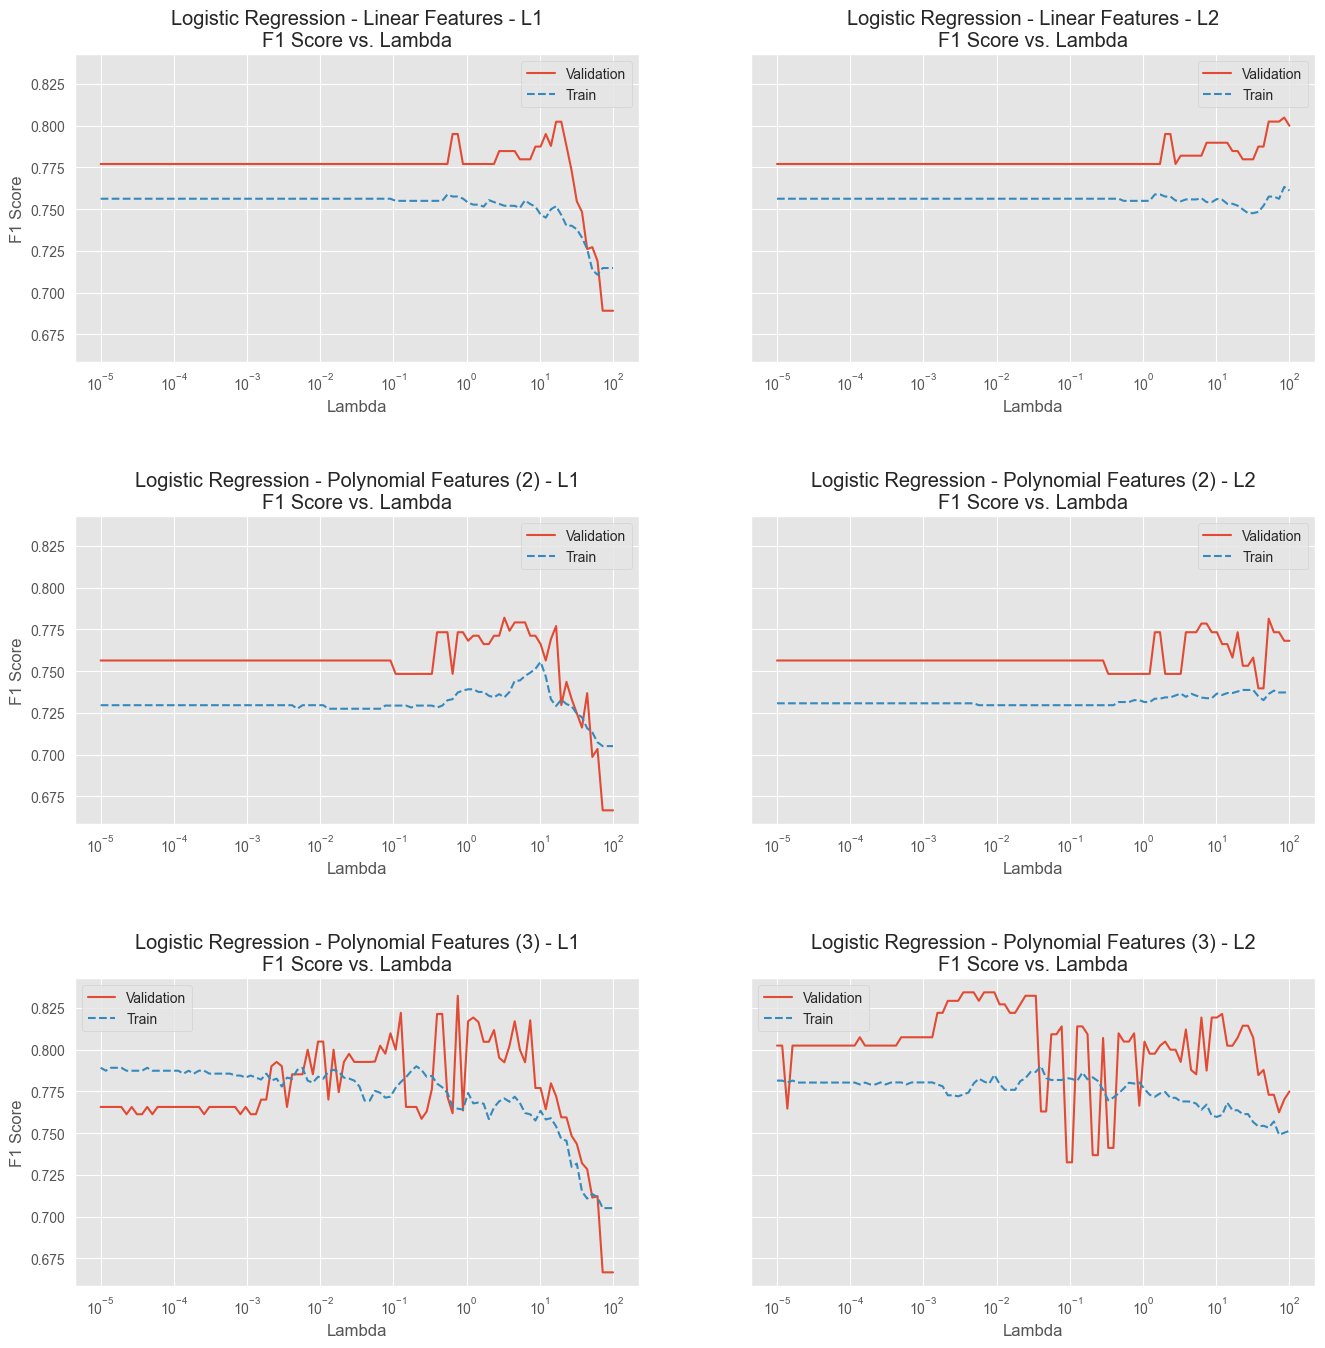

In [71]:
evaluated_models = [
    "clf_logistic1_l1", "clf_logistic1_l2",
    "clf_logistic2_l1", "clf_logistic2_l2",
    "clf_logistic3_l1", "clf_logistic3_l2"
]

evaluated_model_names = [
    "Logistic Regression - Linear Features - L1", "Logistic Regression - Linear Features - L2",
    "Logistic Regression - Polynomial Features (2) - L1", "Logistic Regression - Polynomial Features (2) - L2",
    "Logistic Regression - Polynomial Features (3) - L1", "Logistic Regression - Polynomial Features (3) - L2"
]


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16), sharey="all", gridspec_kw={'hspace': 0.5})
axes = axes.ravel()

i = 0
for axis in axes:
    # Extract the F1 scores and lambda values from clfs
    lambdas = [clf["lambda"] for clf in clfs[evaluated_models[i]]]
    train_f1 = [clf["train_f1"] for clf in clfs[evaluated_models[i]]]
    val_f1 = [clf["val_f1"] for clf in clfs[evaluated_models[i]]]

    # Create a dataframe for plotting
    df = pd.DataFrame({"lambda": lambdas, "train_f1": train_f1, "val_f1": val_f1})

    # Plot the F1 scores over different values of lambda
    sns.lineplot(x="lambda", y="val_f1", data=df, label="Validation", ax=axis)
    sns.lineplot(x="lambda", y="train_f1", data=df, label="Train", ax=axis, linestyle="--")
    axis.set_xlabel("Lambda")
    axis.set_ylabel("F1 Score")
    axis.set_title(f"{evaluated_model_names[i]}\nF1 Score vs. Lambda")
    axis.set_xscale("log")

    i = i + 1


plt.show()
fig.savefig("../images/TrainingResults_LogisticRegression.png")

#### 1.6.1. Observation

All models seem to have good fit on the problem, however:

- $L_1$ (Lasso) Regularization clearly is not a good choice for our problem, as the larger $\lambda$ (lambda) grows, the worse our models' performance gets, regardless of which degree of polynomial feature it is. This is likely because we have only a few features, and all of them are significant, while Lasso Regularization tends to feature select.
- Thus $L_2$ (Ridge) Regularization is more appropriate for our problem.
- The best performing model is ``.